In [1]:
import os 
os.chdir('../src/')
print(os.getcwd())
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
from traffic_analysis.d00_utils.load_confs import load_parameters
from traffic_analysis.d06_visualisation.plot_frame_level_map import plot_map_over_time
from traffic_analysis.d06_visualisation.plot_video_level_diff import plot_video_stats_diff_distribution
from traffic_analysis.d06_visualisation.plot_video_level_performance import plot_video_level_performance

import numpy as np 
import pandas as pd
params = load_parameters()
pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src


Read in video level data

In [2]:
xml_paths = ["C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\15_2019-06-29_13-01-03.094068_00001.01252.xml",
            "C:\\Users\\Caroline Wang\\OneDrive\\DSSG\\air_pollution_estimation\\annotations\\14_2019-06-29_13-01-19.744908_00001.05900.xml"]

video_level_df = pd.read_csv("../data/carolinetemp/video_level_df.csv",
                    dtype={"camera_id": str},
                    parse_dates=["video_upload_datetime"])
del video_level_df['Unnamed: 0']

Read in frame level data

In [3]:
frame_level_df = pd.read_csv("../data/carolinetemp/frame_level_df.csv",
                    dtype={"camera_id": str},
                    converters={"bboxes": lambda x: [float(coord) for coord in x.strip("[]").split(", ")]}, 
                    parse_dates=["video_upload_datetime"])
del frame_level_df['Unnamed: 0']

Run evaluators

In [4]:
chunk_evaluator = ChunkEvaluator(annotation_xml_paths=xml_paths,
                                 selected_labels=params["selected_labels"],
                                 video_level_df=video_level_df,
                                 frame_level_df = frame_level_df,
                                 video_level_column_order=params["video_level_column_order"])
video_level_performance, video_level_diff = chunk_evaluator.evaluate_video_level()
frame_level_map = chunk_evaluator.evaluate_frame_level()

C:\Users\Caroline Wang\OneDrive\DSSG\air_pollution_estimation\src\traffic_analysis\d05_evaluation\video_level_evaluator.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  'n_videos': 'count'})


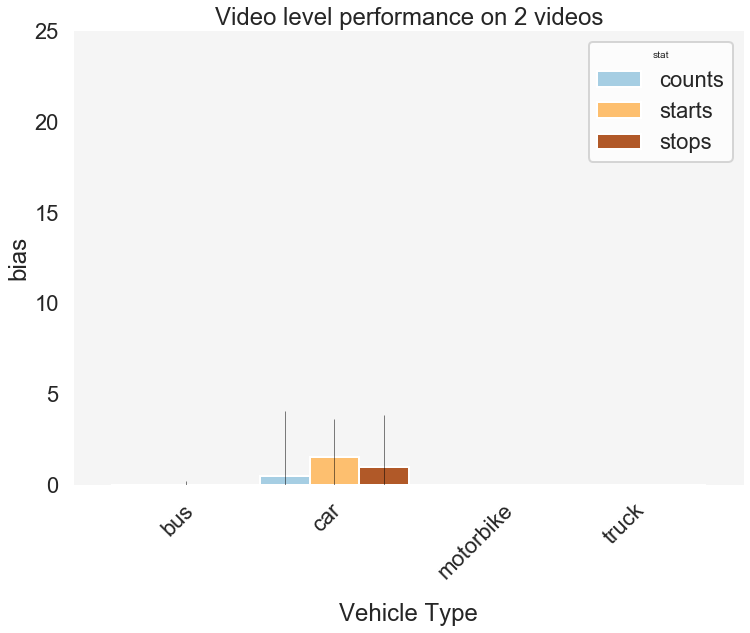

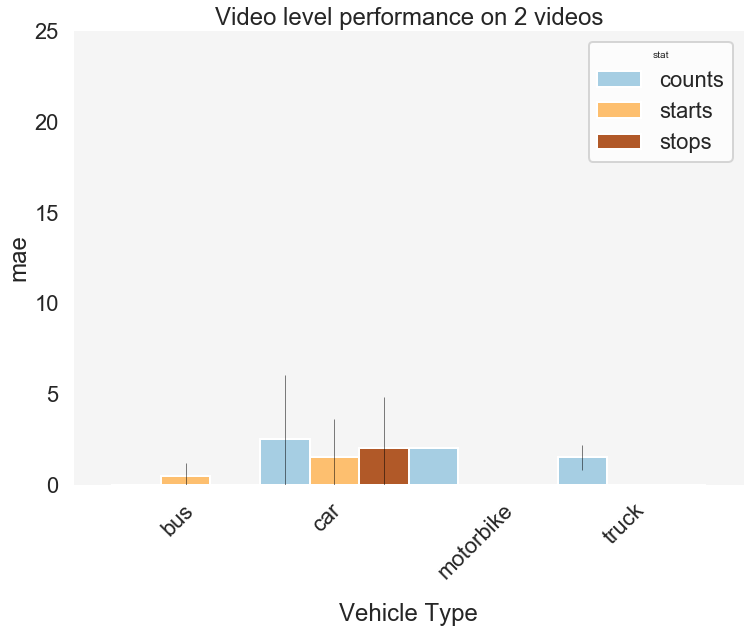

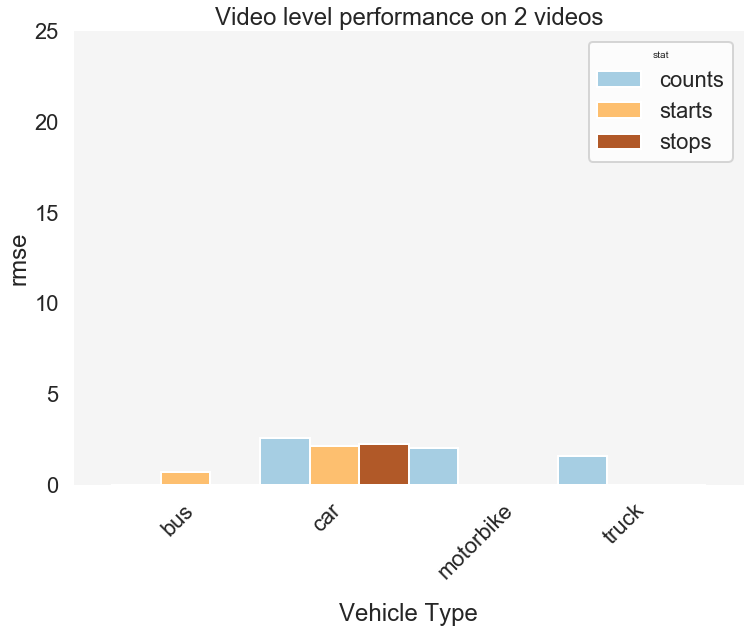

In [5]:
plot_video_level_performance(video_level_performance, 
                       metrics = {'bias':"../data/plots/video_bias_kcf.pdf",
                                  'rmse':"../data/plots/video_rmse_kcf.pdf",
                                   'mae': "../data/plots/video_mae_kcf.pdf"})

Plot video level diffs

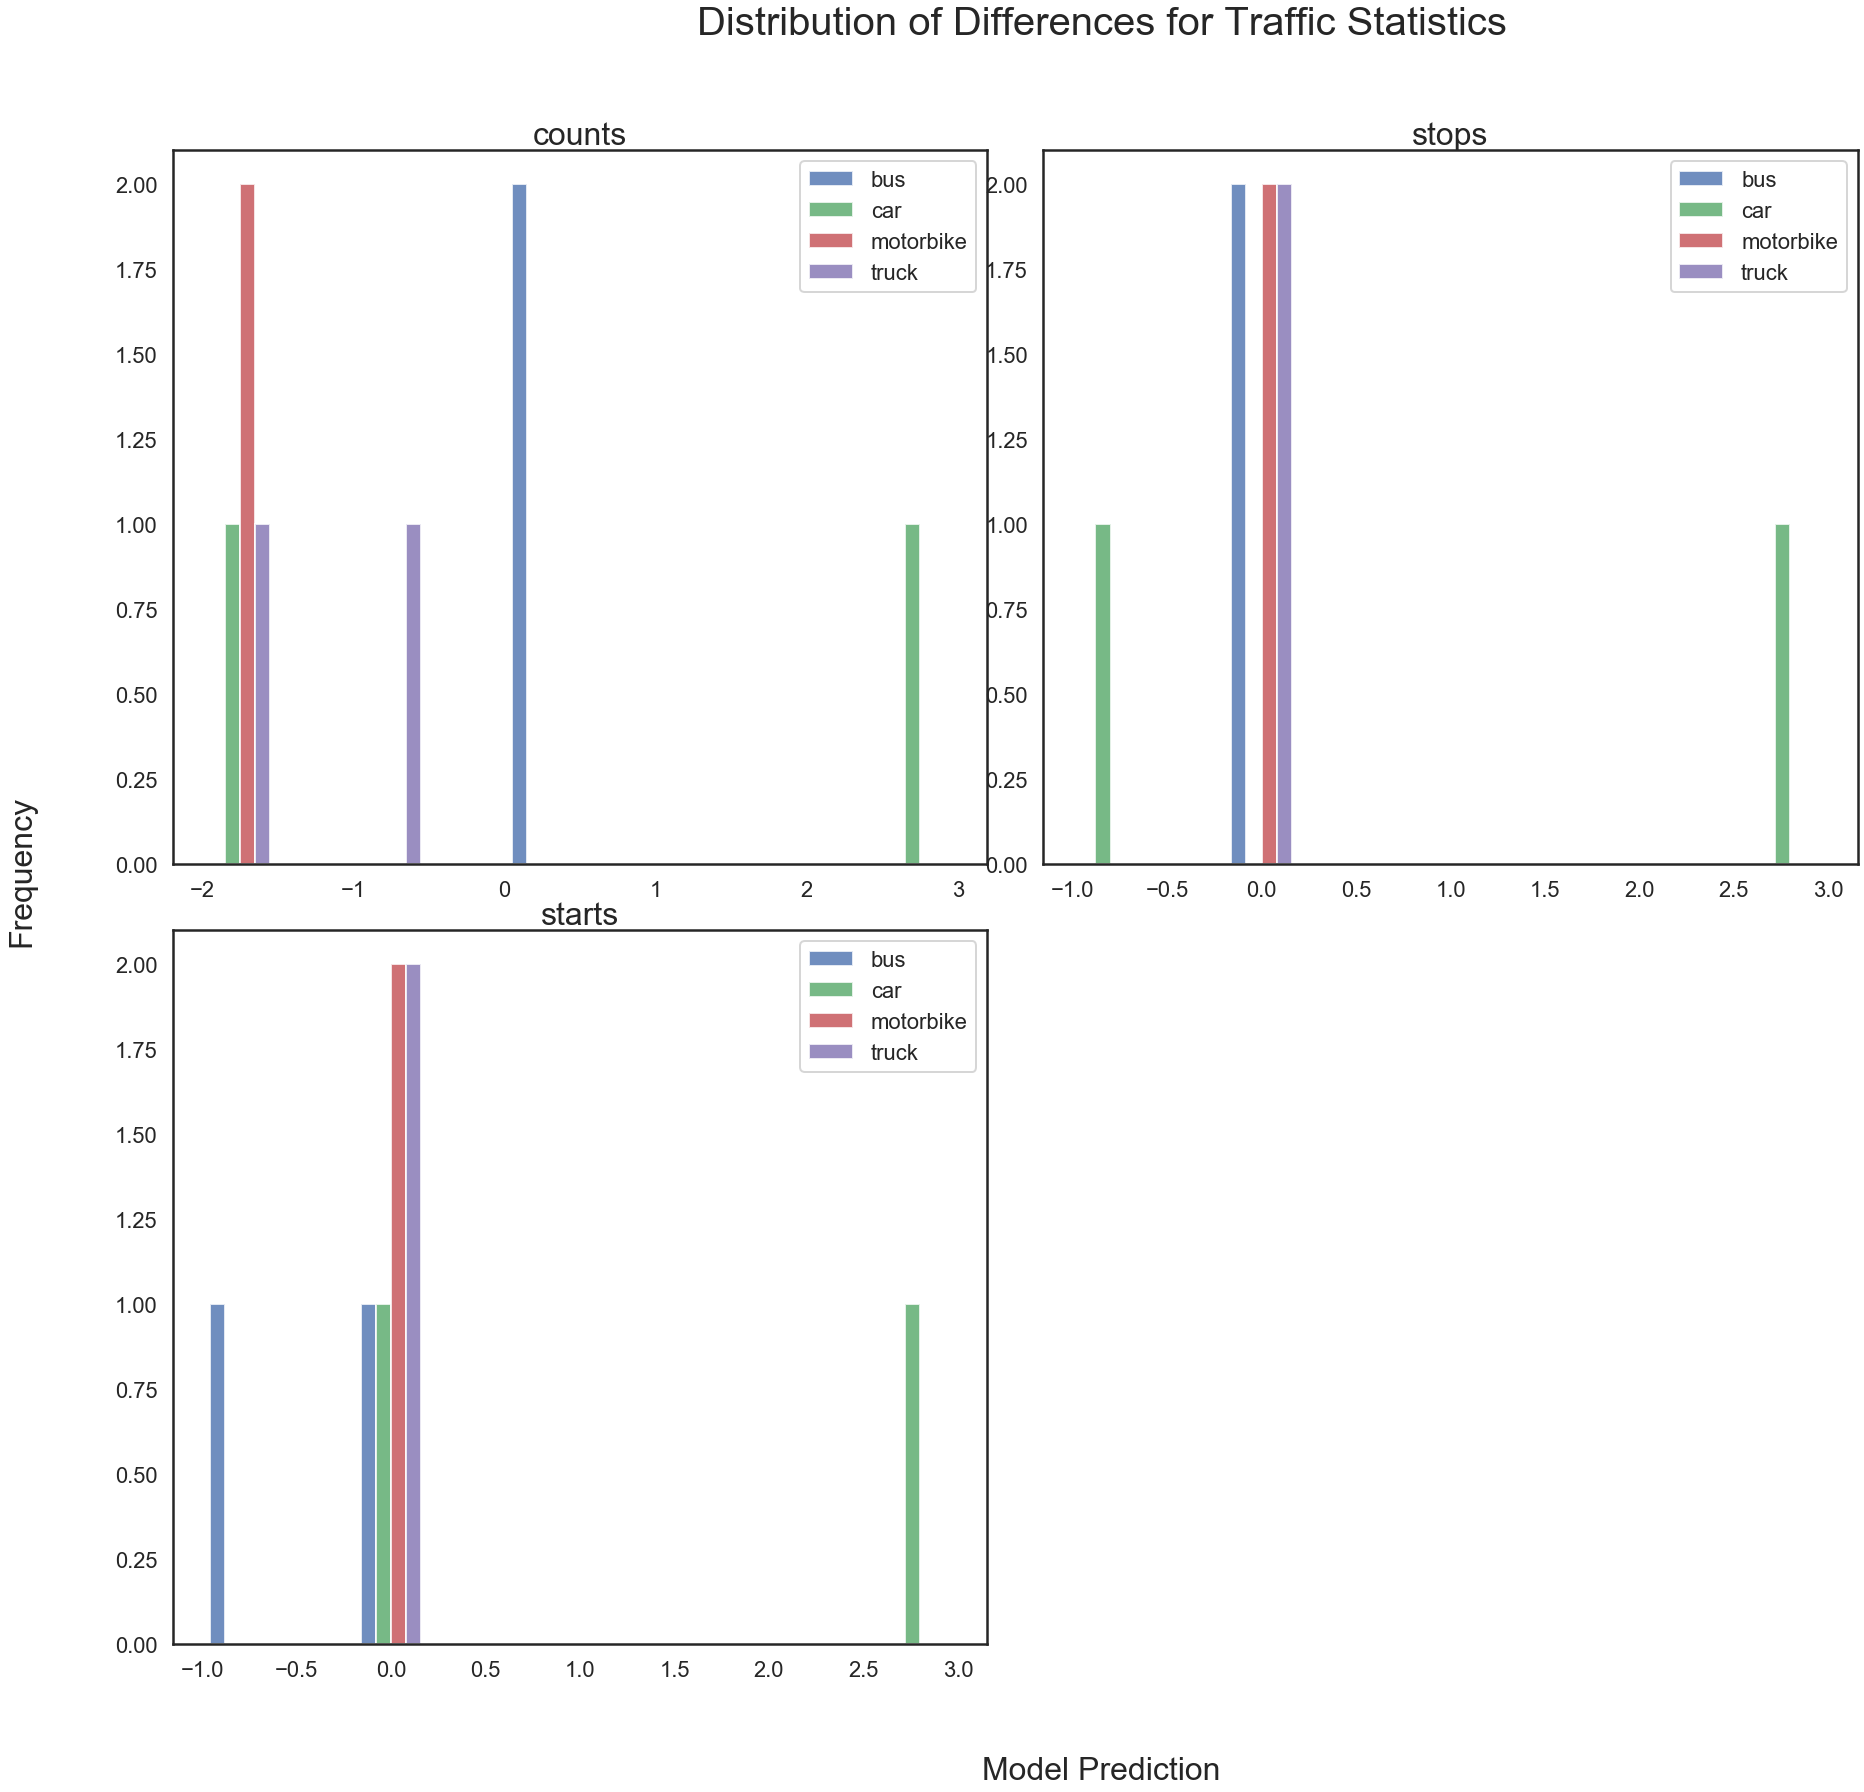

In [6]:
plot_video_stats_diff_distribution(video_level_diff,
                                   video_stat_types = ["counts", "stops", "starts"]
#                                   save_path = "../data/plots/diff_dist_csrt.pdf"
                                  )

## Frame Level Plotting

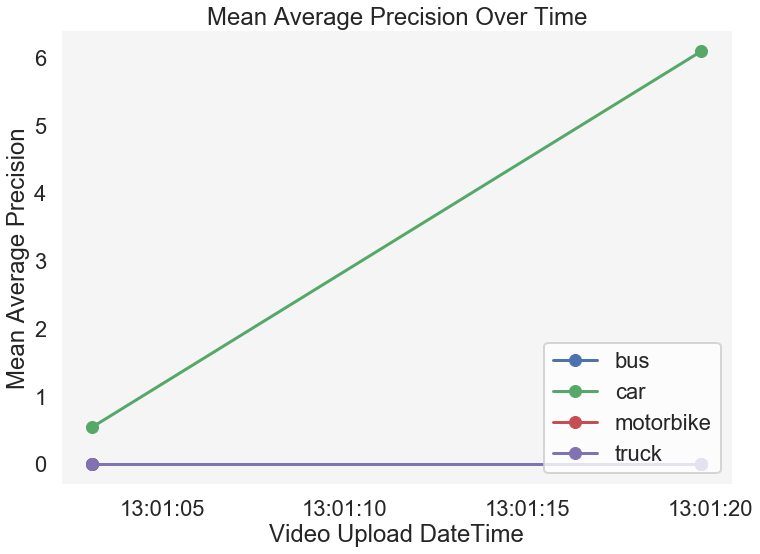

In [7]:
plot_map_over_time(frame_level_map,
                   save_path = "../data/plots/map_over_time.pdf"
                  )